##Get the style and content images


In [ ]:
# Define paths to the style-reference and target image
from tensorflow import keras
from PIL import Image
import keras.utils as image

base_image_path = keras.utils.get_file("sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg") # path to the content image
style_reference_image_path = keras.utils.get_file("starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg") # path to the style image
original_width, original_height = keras.preprocessing.image.load_img(base_image_path).size

# Dimensions of generated picture
img_height = 400
img_width = round(original_width * img_height / original_height)

##Plot images

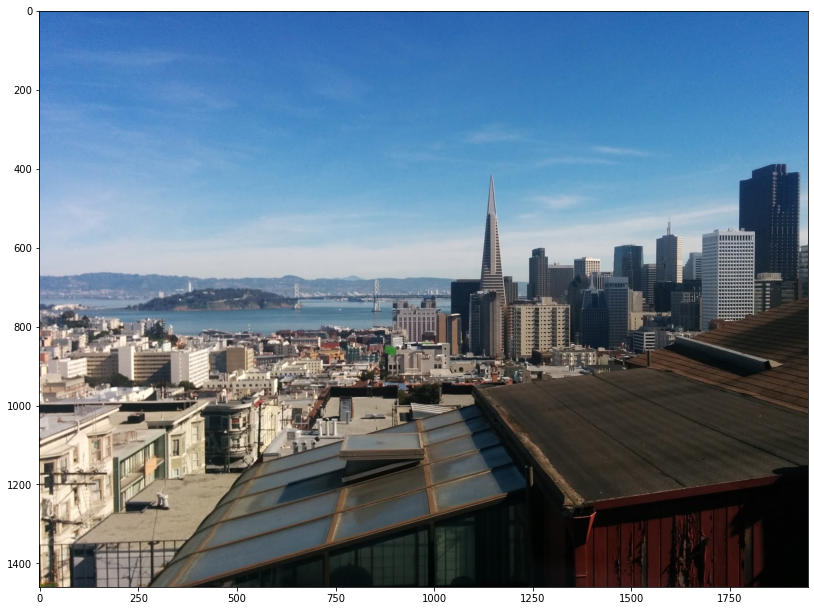

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

plt.figure().add_axes([0, 0, 2, 2]) # creates the size of the figure [left, bottom, width, height (range 0 to 2)]
plt.imshow(load_img(base_image_path))

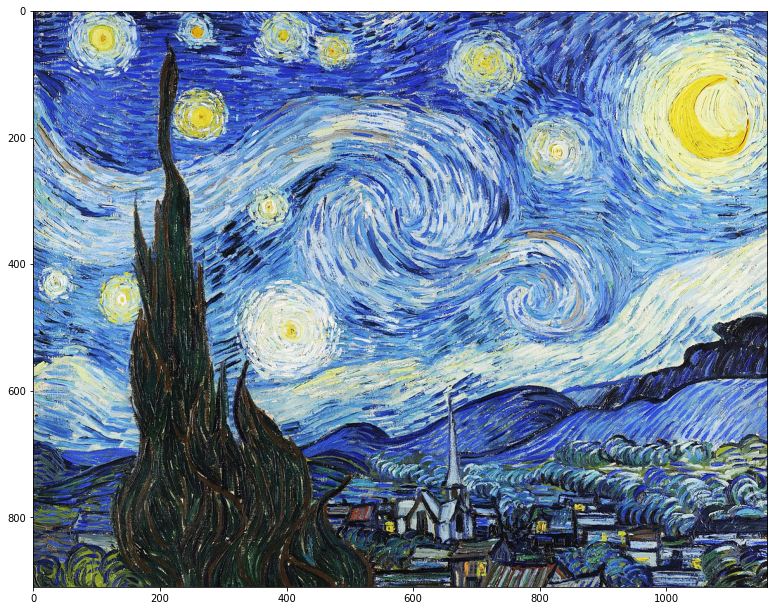

In [ ]:
plt.figure().add_axes([0, 0, 2, 2])
plt.imshow(load_img(style_reference_image_path))

##Helper functions

In [ ]:
# helper functions for loading, preprocessing, and postprocessing
import numpy as np

# Util function to open, resize and format pictures into appropriate arrays
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

# Util function to convert a NumPy array into a valid image
def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    # Zero-centering by removing the mean pixel value from ImageNet (reverses transformation by vgg19.preprocess_input)
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1] # Convert images from 'BGR' to 'RGB' (also a reversal of vgg19.preprocess_input)
    img = np.clip(img, 0, 255).astype("uint8")
    return img

## Load pretrained VGG19 network and define a feature extractor

In [ ]:
#returns the activations of all intermediate layers
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False) # Build VGG19 model loaded with pre-trained ImageNet weights

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict) # returns activation values for every target layer (as a dict)


80150528/80134624 [==============================] - 1s 0us/step


##Content loss

In [ ]:
# the top layer of the VGG19 convnet should have a similar view of the style image and the combination image
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

##Style loss

In [ ]:
# Helper function to compute the Gram matrix of an input matrix (correlations map found in original feature matrix)
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

##Total variation loss

In [ ]:
# Operates on generated combination image's pixels (provides spatial continuity in generated image to avoid overly pixelated results)
def total_variation_loss(x):
    a = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :])
    b = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

##Define the final loss to minimize

In [ ]:
"""
The minimized loss is a weighted average of above three losses. To compute the content
loss, only use one upper layer—the block5_conv2 layer—whereas for the style loss,
use a list of layers that spans both low-level and high-level layers. Add the total variation
loss at the end. A higher content_weight means the target content will be more recognizable in the generated
image.
"""
# List of layers for style loss
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2" # the content loss layer
total_variation_weight = 1e-6 # total variation loss of contribution weight 
style_weight = 1e-6 # style loss contribution weight 
content_weight = 2.5e-8 # Contribution weight of the content loss

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=()) # Initialize loss to 0
    
    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)
    
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value
    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

##Set up the gradient-descent process

In [ ]:
"""
Leverage an optimizer SGD feature: a learning rate schedule. Use it to gradually decrease the
learning rate from a very high value (100) to a much smaller final value (about 20). i.e., 
make fast progress in the early stages of training, then proceed more cautiously closer to the loss minimum:
"""
import tensorflow as tf

@tf.function # accelerate training step by compiling it as a tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay( 
        initial_learning_rate=100.0, # Start with a learning rate of 100 and decrease it by 4% every 100 steps
        decay_steps=100, decay_rate=0.96))

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path)) # Variable to store combination image to update during training

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)]) # Update combination image in direction that reduces the style transfer loss
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.preprocessing.image.save_img(fname, img) # intervals to save combination image 

Iteration 100: loss=8137.70
Iteration 200: loss=6652.25
Iteration 300: loss=6062.76
Iteration 400: loss=5742.25
Iteration 500: loss=5536.06
Iteration 600: loss=5390.63
Iteration 700: loss=5281.42
Iteration 800: loss=5196.12
Iteration 900: loss=5127.24
Iteration 1000: loss=5070.53
Iteration 1100: loss=5022.72
Iteration 1200: loss=4981.92
Iteration 1300: loss=4946.61
Iteration 1400: loss=4915.78
Iteration 1500: loss=4888.60
Iteration 1600: loss=4864.48
Iteration 1700: loss=4842.94
Iteration 1800: loss=4823.50
Iteration 1900: loss=4806.00
Iteration 2000: loss=4790.17
Iteration 2100: loss=4775.79
Iteration 2200: loss=4762.62
Iteration 2300: loss=4750.55
Iteration 2400: loss=4739.41
Iteration 2500: loss=4729.10
Iteration 2600: loss=4719.57
Iteration 2700: loss=4710.77
Iteration 2800: loss=4702.60
Iteration 2900: loss=4694.98
Iteration 3000: loss=4687.88
Iteration 3100: loss=4681.29
Iteration 3200: loss=4675.12
Iteration 3300: loss=4669.33
Iteration 3400: loss=4663.90
Iteration 3500: loss=46

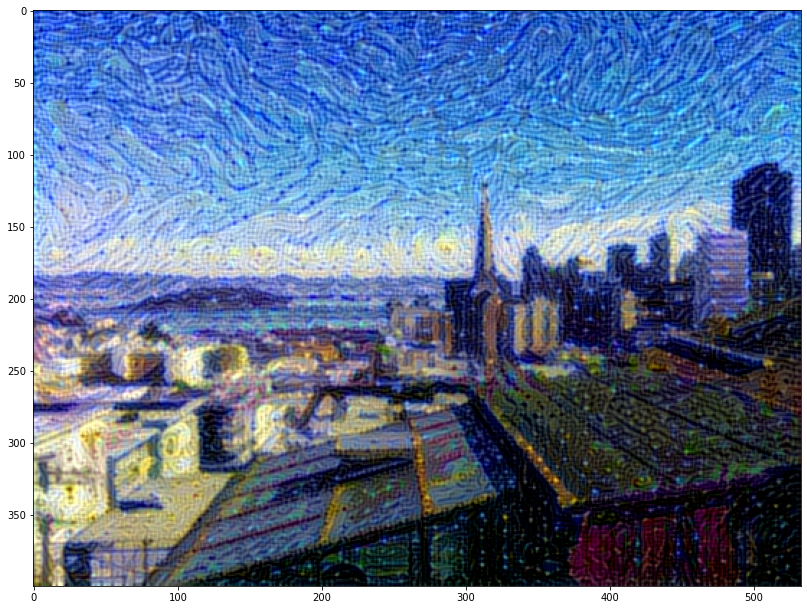

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

plt.figure().add_axes([0, 0, 2, 2])
plt.imshow(deprocess_image(combination_image.numpy()))

# References

From the book "Deep Learning with Python" by FRANÇOIS CHOLLET.